In [1]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import math
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
import numpy as np
from scipy.stats import loguniform
from matplotlib import pyplot

In [2]:
df=pd.read_csv("train_identity.csv").merge(pd.read_csv("train_transaction.csv"), how="right", left_on= "TransactionID", right_on= "TransactionID")

In [3]:
for c in df.columns:
    df[c] = df[c].replace(np.nan, 0)

In [4]:
lista_de_fraud = df.filter(["TransactionID", "isFraud"])

In [5]:
del df["TransactionID"]

In [6]:
division_tran_validation = int(df["TransactionDT"][len(df)-1]*0.80)

In [7]:
df_train = df[df["TransactionDT"] <= division_tran_validation]

In [8]:
df_train_y = df_train["isFraud"]

In [9]:
df_validation = df[df["TransactionDT"] > division_tran_validation]

In [10]:
df_validation_y = df_validation["isFraud"]

In [11]:
del df_validation["isFraud"]

In [12]:
%reset_selective -f "^df$"

In [13]:
lista_de_diccs = {}

In [14]:
for c in df_train.columns:
    if df_train[c].dtype==object: 
        dict_actual=df_train.groupby([c])['isFraud'].mean().to_dict()
        lista_de_diccs[c]=dict_actual
        df_train[c]= df_train[c].map(dict_actual)

In [15]:
del df_train["isFraud"]

In [16]:
for c in df_validation.columns:
    if df_validation[c].dtype==object: 
        df_validation[c]= df_validation[c].map(lista_de_diccs[c])

In [17]:
model = LogisticRegression(C=0.1, max_iter=200)

In [18]:
space = dict()
space['solver'] = ['newton-cg', 'liblinear', "lbgfs"]
space['penalty'] = ['l2']
space['C'] = [0.1]

In [19]:
for c in df_validation.columns:
    if df_validation[c].dtype==object:
        print( df_validation[c])

In [20]:
searcher = RandomizedSearchCV(model, space,cv=3, random_state=1, n_iter=4, n_jobs=1)

In [21]:
searcher.fit(df_train, df_train_y)

/home/bruno/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=4. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  wa

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/bruno/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warning

RandomizedSearchCV(cv=3, estimator=LogisticRegression(C=0.1, max_iter=200),
                   n_iter=4, n_jobs=1,
                   param_distributions={'C': [0.1], 'penalty': ['l2'],
                                        'solver': ['newton-cg', 'liblinear',
                                                   'lbgfs']},
                   random_state=1)

In [22]:
import pickle
with open('model_backup', 'wb') as model_backup_file:
    pickle.dump(searcher, model_backup_file)

In [20]:
import pickle
with open('model_backup', 'rb') as file:
    searcher = pickle.load(file)

In [21]:
for c in df_validation.columns:
    df_validation[c] = df_validation[c].replace(np.nan, 0)

In [22]:
print(classification_report( df_validation_y, searcher.best_estimator_.predict(df_validation)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    101464
           1       0.03      0.00      0.00      3571

    accuracy                           0.96    105035
   macro avg       0.50      0.50      0.49    105035
weighted avg       0.93      0.96      0.95    105035



In [23]:
roc_auc_score(df_validation_y, searcher.best_estimator_.predict_proba(df_validation)[:,1])

0.702981032012259

In [24]:
#%reset_selective -f "^df_train$"
%reset_selective -f "^df_validation$"

In [25]:
df = pd.read_csv("test_identity.csv").merge(pd.read_csv("test_transaction.csv"), how="right", left_on= "TransactionID", right_on= "TransactionID")

In [26]:
transactionid = df["TransactionID"]

In [27]:
del df["TransactionID"]

In [28]:
for k in df.columns:
    df.rename(columns={k: k.replace("id-", "id_")}, inplace=True)

In [29]:
for k in df.columns:
    if df[k].dtype==object: 
        df[k]= df[k].map(lista_de_diccs[k])
    df[k].replace(np.nan, 0, inplace=True)

In [30]:
pd.DataFrame({"TransactionID":transactionid, "isFraud":list(searcher.best_estimator_.predict_proba(df)[:,1])}).set_index("TransactionID").to_csv("df_entrega_concurso_LogisticRegression.csv")

## Puntaje Final del concurso para LogisticRegression
### 0.756836

In [31]:
importancia = []
for i in range(len(searcher.best_estimator_.coef_[0])):
    importancia.append(searcher.best_estimator_.coef_[0][i]/df_train[df_train.columns[i]].mean())

In [32]:
ordenada = sorted(importancia)

In [33]:
importancia_a_mandar = pd.DataFrame(importancia).rename(columns={0:"importancia"}).nlargest(100, "importancia")
los_20_mas_importantes=pd.DataFrame(importancia).rename(columns={0:"importancia"}).nlargest(20, "importancia")

In [34]:
los_20_mas_importantes.index = los_20_mas_importantes.index.map(lambda x: df_train.columns[x])

In [35]:
#los_20_mas_importantes=importancia[importancia[0].isin(ordenada[-20:])].rename(columns={0:"importancia"}).sort_values("importancia")

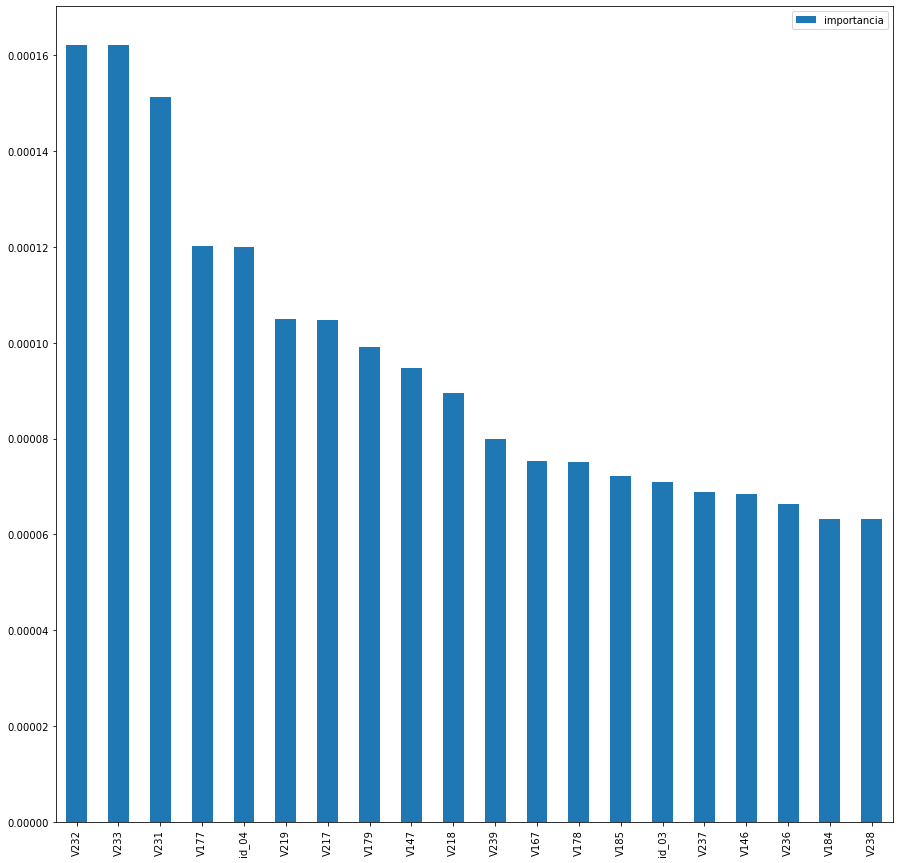

In [36]:
los_20_mas_importantes.plot.bar(figsize=(15,15))

In [38]:
#me guardo los 100 features mas importantes de este modelo para la parte 3
import pickle
with open('features_importantes', 'wb') as model_backup_file:
    pickle.dump(importancia_a_mandar, model_backup_file)